### Required Modules

In [125]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scripts.utils import train_keys

In [44]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data 

In [6]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data.pkl")

X_train, Y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()

validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/validation_data.pkl")

X_val, Y_val = validation_data.iloc[:,:-1].to_numpy(), validation_data.iloc[:,-1].to_numpy()

<AxesSubplot:>

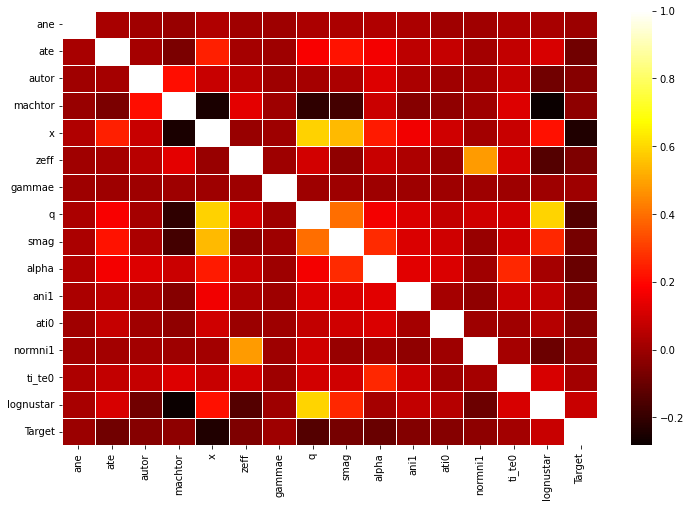

In [53]:
#corr = train_data.corr()

plt.figure(figsize = (12,8))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths = .5, cmap = "hot")

In [8]:
# standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_val = scaler.transform (X_val)

###  Best Neural Network Classifier From Initial Grid Search

**Initial Grid Search Parameters**

Number of nodes: [5,10, 20, 30]

Number of layers: [2,3,4]

In [9]:
file_path = '/share/rcifdata/jbarr/UKAEAGroupProject/grid_search/'
trainings = []
for i in range(336):
    trial_dict = pickle.load(open(file_path+"trial_"+str(i)+".pkl", 'rb'))
    trainings.append(trial_dict)

In [10]:
### calculate the number of parameters
def model_params(nodes, n_inputs=15):
    nodes.append(1)
    params = 0
    
    # bottle neck, 0 if model doesn't include a bottle neck and 1 if the model does include one.
    bottle_in = 0
    bottle_hidden = 0
    
    # parameters from models
    for i in range(len(nodes)):
        if i == 0:
            if nodes[i] < n_inputs: bottle_in = 1
            params += n_inputs * nodes[i]
        else:
            params += nodes[i-1]* nodes[i]
            
            if nodes[i-1] < nodes[i]: bottle_hidden = 1
    
    # parameters from biases
    for i in nodes: 
        params += i
    return params, bottle_in, bottle_hidden

In [11]:
assert model_params([2,2])[0] == 41

In [12]:
# Find the best architecture
best_trial = None 
best_val_acc = - sys.float_info.max
val_accs = []
n_params = []
bottle_in = []
bottle_hid = []

for trial in trainings:
    val_acc = trial["perfomance"][1]
    
    val_accs.append(val_acc)
    
    n_param, bot_in, bot_hid  = model_params(list(trial['nodes']))
    
    n_params.append(n_param)
    
    bottle_in.append(bot_in)
    bottle_hid.append(bot_hid)
    
    
    
    if val_acc > best_val_acc: 
        best_val_acc = val_acc
        best_trial = trial
        
n_params = np.array(n_params)
bottle_in = np.array(bottle_in)
bottle_hid= np.array(bottle_hid)
val_accs = np.array(val_accs)


In [13]:
print("Best Model\n")
print("Network:",best_trial["nodes"],"\n" )
print("Validation accuracy:", best_trial['perfomance'][1])

Best Model

Network: [30 30 30 30] 

Validation accuracy: 0.8433062434196472


Text(0, 0.5, 'Accuracy')

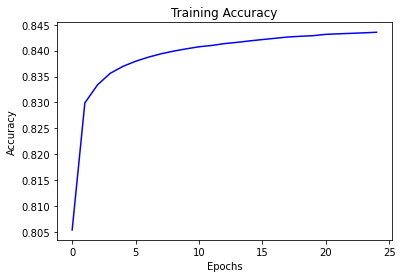

In [14]:
plt.figure()
plt.plot(best_trial["history"]["acc"],color = 'blue')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'MSE')

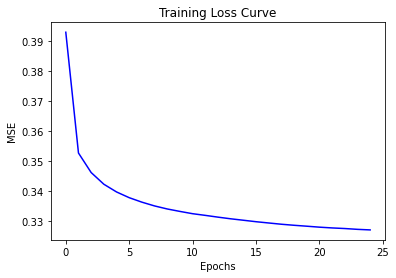

In [16]:
plt.figure()
plt.plot(best_trial["history"]["loss"], color = 'blue')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")

Text(0, 0.5, 'Frequency')

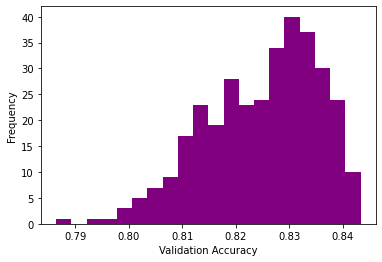

In [17]:
plt.figure()
plt.hist(val_accs, bins = 20, color = 'purple');
plt.xlabel("Validation Accuracy")
plt.ylabel("Frequency")

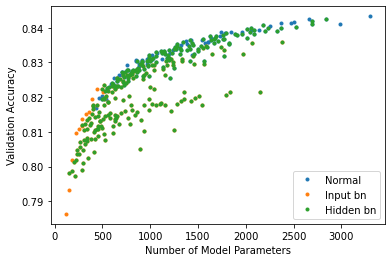

In [18]:
plt.figure()
plt.plot(n_params[np.where(bottle_in == 0)], val_accs[np.where(bottle_in == 0)], '.', label = 'Normal')
plt.plot(n_params[np.where(bottle_in == 1)], val_accs[np.where(bottle_in == 1)], '.', label = 'Input bn')
plt.plot(n_params[np.where(bottle_hid == 1)], val_accs[np.where(bottle_hid == 1)], '.', label = 'Hidden bn')
plt.xlabel("Number of Model Parameters")
plt.ylabel("Validation Accuracy")
plt.legend()

### Grid Search Conclusion

Looking at the plot above we can see that increasing the number of model parameters in general leads to an increase in the models validation accuracy, the graph looks as though it will plateau, but it also suggestes we haven't hit the peak, a further grid search of models with a higher number of parameters should be conducted.

### Final classifier

In [19]:
def nn_classifier():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [20]:
model = nn_classifier()

2022-02-23 21:54:32.599056: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-23 21:54:32.599644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-23 21:54:32.599776: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = 'acc')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [22]:
history = model.fit(x_train, Y_train, validation_data = (x_val, Y_val), batch_size = 4096, epochs =50, callbacks=[stop_early])

2022-02-23 21:54:39.077455: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-23 21:54:39.078471: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


Epoch 1/50
816/816 [==============================] - 9s 10ms/step - loss: 0.5382 - acc: 0.7056 - val_loss: 0.4369 - val_acc: 0.7775
Epoch 2/50
816/816 [==============================] - 7s 8ms/step - loss: 0.4265 - acc: 0.7854 - val_loss: 0.3979 - val_acc: 0.8050
Epoch 3/50
816/816 [==============================] - 6s 8ms/step - loss: 0.3915 - acc: 0.8092 - val_loss: 0.3789 - val_acc: 0.8152
Epoch 4/50
816/816 [==============================] - 6s 8ms/step - loss: 0.3761 - acc: 0.8170 - val_loss: 0.3701 - val_acc: 0.8201
Epoch 5/50
816/816 [==============================] - 6s 8ms/step - loss: 0.3695 - acc: 0.8209 - val_loss: 0.3656 - val_acc: 0.8229
Epoch 6/50
816/816 [==============================] - 6s 8ms/step - loss: 0.3650 - acc: 0.8235 - val_loss: 0.3630 - val_acc: 0.8243
Epoch 7/50
816/816 [==============================] - 6s 8ms/step - loss: 0.3624 - acc: 0.8246 - val_loss: 0.3591 - val_acc: 0.8266
Epoch 8/50
816/816 [==============================] - 6s 8ms/step - loss: 0

In [ ]:
!mkdir -p saved_model
model.save('saved_model/classifier_model')

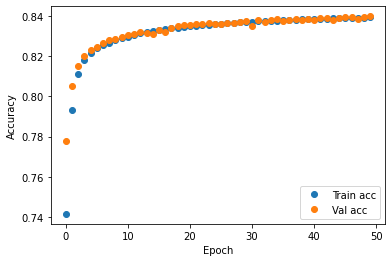

In [23]:
plt.figure()
plt.plot(history.history['acc'], 'o', label = 'Train acc')
plt.plot(history.history['val_acc'], 'o', label = 'Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

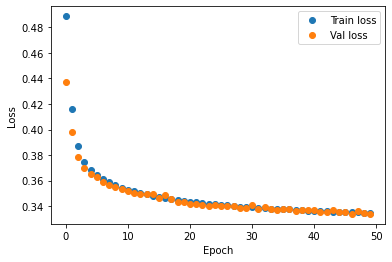

In [24]:
plt.figure()
plt.plot(history.history['loss'], 'o', label = 'Train loss')
plt.plot(history.history['val_loss'], 'o', label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Evaluate Model on Test Set

In [25]:
from sklearn.metrics import roc_curve

In [26]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data.pkl")

X_test, Y_test = test_data.iloc[:,:-1].to_numpy(), test_data.iloc[:,-1].to_numpy()

In [27]:
x_test = scaler.transform(X_test)

In [28]:
predictions = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(Y_test, predictions)

In [29]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, predictions)

Text(0.8, 0.2, 'auc =  0.92')

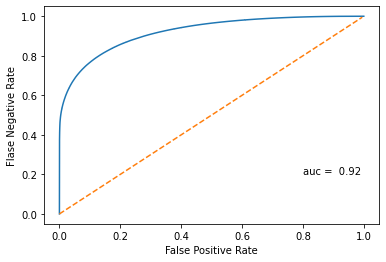

In [30]:
plt.figure()
plt.plot(fpr, tpr)
random_class = np.arange(0,1,0.005)
plt.plot(random_class, random_class, '--')
plt.xlabel('False Positive Rate')
plt.ylabel('Flase Negative Rate')
plt.text(0.8, 0.2, f'auc = {auc: .2f}', fontsize=10)

In [31]:
test_pred = np.where(predictions < 0.5, predictions, 1)
test_pred = np.where(predictions >= 0.5, test_pred, 0)

In [32]:
n_positive = np.where(Y_test ==0)[0].shape[0]
n_negative = np.where(Y_test ==1)[0].shape[0]
div_arr = np.array([[n_positive, n_negative]]).T

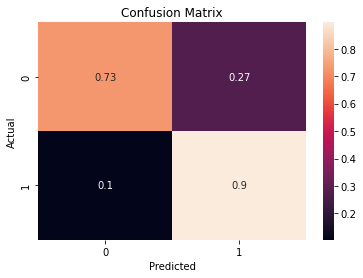

In [33]:
con_mat = confusion_matrix(Y_test, test_pred, labels =[0,1])/div_arr
sns.heatmap(con_mat, annot=True).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

### Distributions from classifier

In [34]:
preds = np.round(predictions).flatten()

In [35]:
no_output = x_test[np.where(preds == 0)]
yes_output = x_test[np.where(preds == 1)] 
assert no_output.shape[0] + yes_output.shape[0] == x_test.shape[0]

In [36]:
columns = list(train_data.iloc[:,:-1].columns)
print(columns)

['ane', 'ate', 'autor', 'machtor', 'x', 'zeff', 'gammae', 'q', 'smag', 'alpha', 'ani1', 'ati0', 'normni1', 'ti_te0', 'lognustar']


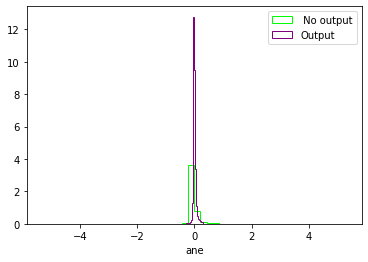

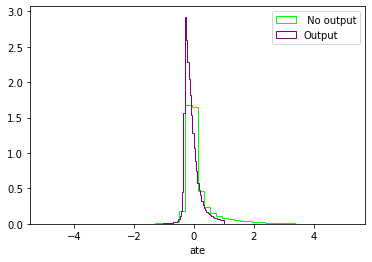

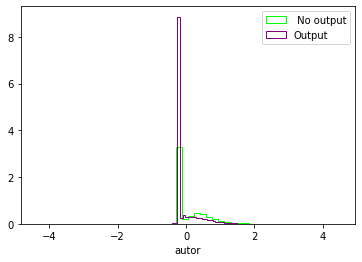

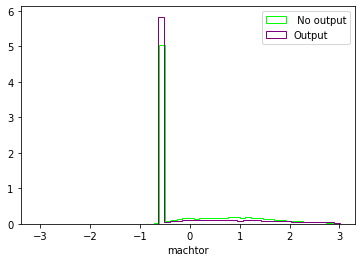

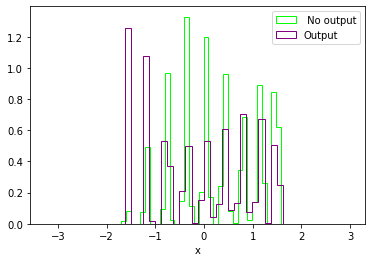

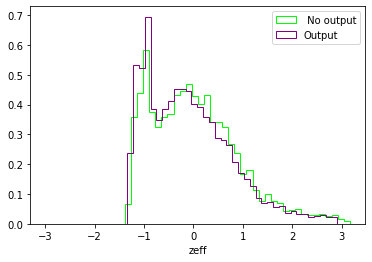

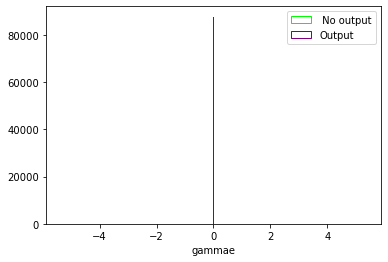

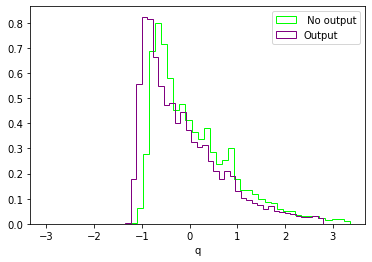

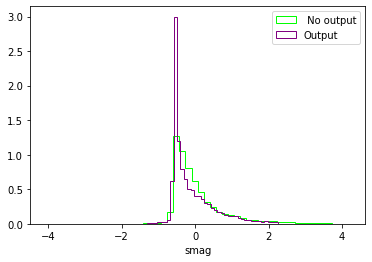

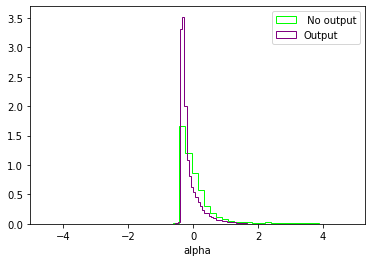

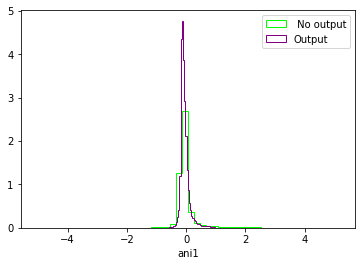

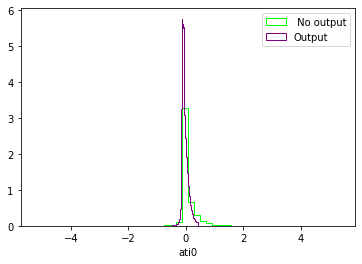

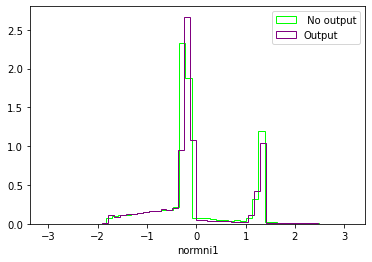

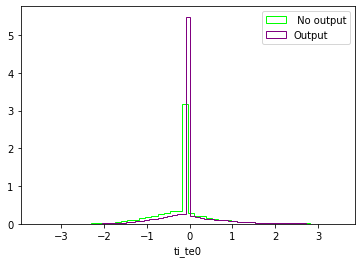

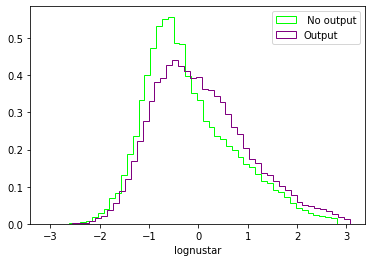

In [37]:
for i, column in enumerate(columns):
    # find the mean and std 
    mean_no, mean_yes = np.mean(no_output[:,i]), np.mean(yes_output[:,i])
    std_no, std_yes = np.std(no_output[:,i]), np.std(yes_output[:,i])
    
    no_lower, no_upper = (mean_no - 3*std_no), (mean_no + 3*std_no)
    yes_lower, yes_upper = (mean_yes - 3*std_yes), (mean_yes + 3*std_yes)
    
    plt.figure()
    plt.hist(no_output[:,i], histtype = 'step', color = 'lime',
             label =" No output", density = True, bins =50, range = (no_lower, no_upper));
    
    plt.hist(yes_output[:,i], histtype = 'step', color = 'purple',
             label = "Output", density = True, bins = 50, range = (yes_lower,yes_upper ));
    plt.legend()
    plt.xlabel(column)

# Train model with varying number of data points

In [38]:
# def nn_classifier_big():
#     model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1, activation = 'sigmoid')   
#     ])
#     return model
def nn_classifier_big():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [39]:
val_indices = np.random.choice(x_val.shape[0], size = 100_000, replace=False)
x_val_sample = x_val[val_indices]
y_val_sample = Y_val[val_indices]

In [40]:
training_size = [100, 500, 1000, 2000, 5000,
                 7500, 10_000, 12_500, 15_000, 20_000, 30_000, 50_000,
                 100_000, 200_000, 500_000,
                 1_000_000, x_train.shape[0]]
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

permuted_idx = np.random.permutation(x_train.shape[0])
permuted_x = x_train[permuted_idx]
permuted_y = Y_train[permuted_idx]

for size in training_size:

    x_sample = permuted_x[:size]
    y_sample = permuted_y[:size]
    
    batch_size = size if size <= 10_000 else 4096
    
    print(f"Training model with {size} training points:")
    model = nn_classifier_big()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'acc')
    stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5)
    history = model.fit(x_sample,
                        y_sample,
                        validation_data = (x_val_sample, y_val_sample),
                        batch_size = batch_size,
                        epochs = 100,
                        callbacks = [stop_early])
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])
    
    print("\n \n")

Training model with 100 training points:
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6776 - acc: 0.6000 - val_loss: 0.6776 - val_acc: 0.6561
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.6681 - acc: 0.6300 - val_loss: 0.6743 - val_acc: 0.6584
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.6740 - acc: 0.6400 - val_loss: 0.6712 - val_acc: 0.6603
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.6747 - acc: 0.6300 - val_loss: 0.6683 - val_acc: 0.6605
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.6433 - acc: 0.6700 - val_loss: 0.6656 - val_acc: 0.6606
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.6456 - acc: 0.6600 - val_loss: 0.6630 - val_acc: 0.6608
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.6367 - acc: 0.6600 - val_loss: 0.6606 - val_acc: 0.6609
Epoch 8/100
1/1 [==============================] - 1s 1s/step -

1/1 [==============================] - 0s 185ms/step - loss: 0.6540 - acc: 0.6600 - val_loss: 0.6504 - val_acc: 0.6629
Epoch 25/100
1/1 [==============================] - 0s 186ms/step - loss: 0.6445 - acc: 0.6650 - val_loss: 0.6490 - val_acc: 0.6633
Epoch 26/100
1/1 [==============================] - 0s 185ms/step - loss: 0.6430 - acc: 0.6730 - val_loss: 0.6475 - val_acc: 0.6639
Epoch 27/100
1/1 [==============================] - 0s 185ms/step - loss: 0.6410 - acc: 0.6560 - val_loss: 0.6461 - val_acc: 0.6643
Epoch 28/100
1/1 [==============================] - 0s 185ms/step - loss: 0.6383 - acc: 0.6710 - val_loss: 0.6447 - val_acc: 0.6649
Epoch 29/100
1/1 [==============================] - 0s 185ms/step - loss: 0.6406 - acc: 0.6710 - val_loss: 0.6434 - val_acc: 0.6655
Epoch 30/100
1/1 [==============================] - 0s 186ms/step - loss: 0.6340 - acc: 0.6740 - val_loss: 0.6420 - val_acc: 0.6657
Epoch 31/100
1/1 [==============================] - 0s 184ms/step - loss: 0.6341 - acc: 0

Epoch 48/100
1/1 [==============================] - 0s 137ms/step - loss: 0.5980 - acc: 0.6770 - val_loss: 0.5939 - val_acc: 0.6693
Epoch 49/100
1/1 [==============================] - 0s 136ms/step - loss: 0.5906 - acc: 0.6720 - val_loss: 0.5928 - val_acc: 0.6697
Epoch 50/100
1/1 [==============================] - 0s 136ms/step - loss: 0.5959 - acc: 0.6685 - val_loss: 0.5918 - val_acc: 0.6701
Epoch 51/100
1/1 [==============================] - 0s 137ms/step - loss: 0.5864 - acc: 0.6710 - val_loss: 0.5908 - val_acc: 0.6704
Epoch 52/100
1/1 [==============================] - 0s 138ms/step - loss: 0.5885 - acc: 0.6745 - val_loss: 0.5898 - val_acc: 0.6709
Epoch 53/100
1/1 [==============================] - 0s 137ms/step - loss: 0.5894 - acc: 0.6665 - val_loss: 0.5888 - val_acc: 0.6712
Epoch 54/100
1/1 [==============================] - 0s 137ms/step - loss: 0.5843 - acc: 0.6810 - val_loss: 0.5879 - val_acc: 0.6714
Epoch 55/100
1/1 [==============================] - 0s 137ms/step - loss: 0.

Epoch 10/100
1/1 [==============================] - 0s 114ms/step - loss: 0.6409 - acc: 0.6632 - val_loss: 0.6342 - val_acc: 0.6615
Epoch 11/100
1/1 [==============================] - 0s 113ms/step - loss: 0.6381 - acc: 0.6632 - val_loss: 0.6317 - val_acc: 0.6615

 

Training model with 7500 training points:
Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.7368 - acc: 0.3640 - val_loss: 0.7245 - val_acc: 0.3512
Epoch 2/100
1/1 [==============================] - 0s 105ms/step - loss: 0.7281 - acc: 0.3777 - val_loss: 0.7172 - val_acc: 0.3789
Epoch 3/100
1/1 [==============================] - 0s 103ms/step - loss: 0.7216 - acc: 0.3944 - val_loss: 0.7105 - val_acc: 0.4117
Epoch 4/100
1/1 [==============================] - 0s 104ms/step - loss: 0.7145 - acc: 0.4135 - val_loss: 0.7045 - val_acc: 0.4521
Epoch 5/100
1/1 [==============================] - 0s 104ms/step - loss: 0.7079 - acc: 0.4480 - val_loss: 0.6990 - val_acc: 0.4914
Epoch 6/100
1/1 [=====================

Epoch 61/100
1/1 [==============================] - 0s 120ms/step - loss: 0.5923 - acc: 0.6651 - val_loss: 0.5874 - val_acc: 0.6687
Epoch 62/100
1/1 [==============================] - 0s 119ms/step - loss: 0.5941 - acc: 0.6629 - val_loss: 0.5867 - val_acc: 0.6690
Epoch 63/100
1/1 [==============================] - 0s 119ms/step - loss: 0.5931 - acc: 0.6669 - val_loss: 0.5861 - val_acc: 0.6695
Epoch 64/100
1/1 [==============================] - 0s 120ms/step - loss: 0.5908 - acc: 0.6676 - val_loss: 0.5854 - val_acc: 0.6697
Epoch 65/100
1/1 [==============================] - 0s 120ms/step - loss: 0.5938 - acc: 0.6643 - val_loss: 0.5848 - val_acc: 0.6698
Epoch 66/100
1/1 [==============================] - 0s 125ms/step - loss: 0.5899 - acc: 0.6657 - val_loss: 0.5843 - val_acc: 0.6700
Epoch 67/100
1/1 [==============================] - 0s 116ms/step - loss: 0.5878 - acc: 0.6649 - val_loss: 0.5837 - val_acc: 0.6702
Epoch 68/100
1/1 [==============================] - 0s 116ms/step - loss: 0.

Epoch 23/100
1/1 [==============================] - 0s 116ms/step - loss: 0.6399 - acc: 0.6634 - val_loss: 0.6354 - val_acc: 0.6615
Epoch 24/100
1/1 [==============================] - 0s 115ms/step - loss: 0.6358 - acc: 0.6643 - val_loss: 0.6329 - val_acc: 0.6615
Epoch 25/100
1/1 [==============================] - 0s 116ms/step - loss: 0.6362 - acc: 0.6617 - val_loss: 0.6304 - val_acc: 0.6615
Epoch 26/100
1/1 [==============================] - 0s 117ms/step - loss: 0.6336 - acc: 0.6628 - val_loss: 0.6279 - val_acc: 0.6617
Epoch 27/100
1/1 [==============================] - 0s 116ms/step - loss: 0.6283 - acc: 0.6642 - val_loss: 0.6255 - val_acc: 0.6620
Epoch 28/100
1/1 [==============================] - 0s 117ms/step - loss: 0.6307 - acc: 0.6602 - val_loss: 0.6231 - val_acc: 0.6625
Epoch 29/100
1/1 [==============================] - 0s 129ms/step - loss: 0.6288 - acc: 0.6622 - val_loss: 0.6208 - val_acc: 0.6632
Epoch 30/100
1/1 [==============================] - 0s 116ms/step - loss: 0.

4/4 [==============================] - 0s 45ms/step - loss: 0.5543 - acc: 0.6921 - val_loss: 0.5496 - val_acc: 0.6988
Epoch 43/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5569 - acc: 0.6935 - val_loss: 0.5486 - val_acc: 0.6996
Epoch 44/100
4/4 [==============================] - 0s 49ms/step - loss: 0.5549 - acc: 0.6904 - val_loss: 0.5478 - val_acc: 0.7006
Epoch 45/100
4/4 [==============================] - 0s 45ms/step - loss: 0.5540 - acc: 0.6966 - val_loss: 0.5472 - val_acc: 0.7004
Epoch 46/100
4/4 [==============================] - 0s 45ms/step - loss: 0.5563 - acc: 0.6947 - val_loss: 0.5466 - val_acc: 0.7009
Epoch 47/100
4/4 [==============================] - 0s 45ms/step - loss: 0.5537 - acc: 0.6972 - val_loss: 0.5459 - val_acc: 0.7013
Epoch 48/100
4/4 [==============================] - 0s 45ms/step - loss: 0.5539 - acc: 0.6972 - val_loss: 0.5450 - val_acc: 0.7021
Epoch 49/100
4/4 [==============================] - 0s 45ms/step - loss: 0.5504 - acc: 0.6978 - 

4/4 [==============================] - 0s 47ms/step - loss: 0.5788 - acc: 0.6770 - val_loss: 0.5729 - val_acc: 0.6829
Epoch 24/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5771 - acc: 0.6778 - val_loss: 0.5714 - val_acc: 0.6842
Epoch 25/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5739 - acc: 0.6775 - val_loss: 0.5699 - val_acc: 0.6859
Epoch 26/100
4/4 [==============================] - 0s 46ms/step - loss: 0.5693 - acc: 0.6848 - val_loss: 0.5684 - val_acc: 0.6874
Epoch 27/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5711 - acc: 0.6807 - val_loss: 0.5668 - val_acc: 0.6882
Epoch 28/100
4/4 [==============================] - 0s 46ms/step - loss: 0.5722 - acc: 0.6805 - val_loss: 0.5654 - val_acc: 0.6895
Epoch 29/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5666 - acc: 0.6818 - val_loss: 0.5641 - val_acc: 0.6906
Epoch 30/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5656 - acc: 0.6872 - 

4/4 [==============================] - 0s 47ms/step - loss: 0.5121 - acc: 0.7293 - val_loss: 0.5214 - val_acc: 0.7284
Epoch 86/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5133 - acc: 0.7272 - val_loss: 0.5203 - val_acc: 0.7296
Epoch 87/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5175 - acc: 0.7249 - val_loss: 0.5194 - val_acc: 0.7300
Epoch 88/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5098 - acc: 0.7286 - val_loss: 0.5186 - val_acc: 0.7305
Epoch 89/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5166 - acc: 0.7260 - val_loss: 0.5174 - val_acc: 0.7313
Epoch 90/100
4/4 [==============================] - 0s 50ms/step - loss: 0.5107 - acc: 0.7309 - val_loss: 0.5168 - val_acc: 0.7310
Epoch 91/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5113 - acc: 0.7299 - val_loss: 0.5159 - val_acc: 0.7321
Epoch 92/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5080 - acc: 0.7302 - 

5/5 [==============================] - 0s 38ms/step - loss: 0.5379 - acc: 0.7029 - val_loss: 0.5342 - val_acc: 0.7101
Epoch 48/100
5/5 [==============================] - 0s 38ms/step - loss: 0.5358 - acc: 0.7070 - val_loss: 0.5333 - val_acc: 0.7107
Epoch 49/100
5/5 [==============================] - 0s 38ms/step - loss: 0.5352 - acc: 0.7036 - val_loss: 0.5319 - val_acc: 0.7131
Epoch 50/100
5/5 [==============================] - 0s 38ms/step - loss: 0.5342 - acc: 0.7059 - val_loss: 0.5310 - val_acc: 0.7141
Epoch 51/100
5/5 [==============================] - 0s 38ms/step - loss: 0.5362 - acc: 0.7035 - val_loss: 0.5301 - val_acc: 0.7151
Epoch 52/100
5/5 [==============================] - 0s 38ms/step - loss: 0.5317 - acc: 0.7071 - val_loss: 0.5292 - val_acc: 0.7157
Epoch 53/100
5/5 [==============================] - 0s 38ms/step - loss: 0.5284 - acc: 0.7157 - val_loss: 0.5281 - val_acc: 0.7173
Epoch 54/100
5/5 [==============================] - 0s 38ms/step - loss: 0.5302 - acc: 0.7104 - 

8/8 [==============================] - 0s 26ms/step - loss: 0.5928 - acc: 0.6670 - val_loss: 0.5828 - val_acc: 0.6689
Epoch 10/100
8/8 [==============================] - 0s 26ms/step - loss: 0.5863 - acc: 0.6691 - val_loss: 0.5781 - val_acc: 0.6720
Epoch 11/100
8/8 [==============================] - 0s 26ms/step - loss: 0.5787 - acc: 0.6717 - val_loss: 0.5739 - val_acc: 0.6760
Epoch 12/100
8/8 [==============================] - 0s 26ms/step - loss: 0.5774 - acc: 0.6722 - val_loss: 0.5702 - val_acc: 0.6789
Epoch 13/100
8/8 [==============================] - 0s 26ms/step - loss: 0.5729 - acc: 0.6756 - val_loss: 0.5669 - val_acc: 0.6813
Epoch 14/100
8/8 [==============================] - 0s 26ms/step - loss: 0.5726 - acc: 0.6746 - val_loss: 0.5637 - val_acc: 0.6841
Epoch 15/100
8/8 [==============================] - 0s 26ms/step - loss: 0.5654 - acc: 0.6825 - val_loss: 0.5610 - val_acc: 0.6858
Epoch 16/100
8/8 [==============================] - 0s 26ms/step - loss: 0.5641 - acc: 0.6802 - 

8/8 [==============================] - ETA: 0s - loss: 0.4903 - acc: 0.741 - 0s 26ms/step - loss: 0.4896 - acc: 0.7409 - val_loss: 0.4771 - val_acc: 0.7523
Epoch 72/100
8/8 [==============================] - 0s 26ms/step - loss: 0.4895 - acc: 0.7399 - val_loss: 0.4758 - val_acc: 0.7527
Epoch 73/100
8/8 [==============================] - 0s 29ms/step - loss: 0.4870 - acc: 0.7434 - val_loss: 0.4744 - val_acc: 0.7538
Epoch 74/100
8/8 [==============================] - 0s 26ms/step - loss: 0.4837 - acc: 0.7431 - val_loss: 0.4735 - val_acc: 0.7547
Epoch 75/100
8/8 [==============================] - 0s 26ms/step - loss: 0.4896 - acc: 0.7434 - val_loss: 0.4724 - val_acc: 0.7558
Epoch 76/100
8/8 [==============================] - 0s 26ms/step - loss: 0.4819 - acc: 0.7467 - val_loss: 0.4715 - val_acc: 0.7551
Epoch 77/100
8/8 [==============================] - 0s 26ms/step - loss: 0.4851 - acc: 0.7450 - val_loss: 0.4702 - val_acc: 0.7564
Epoch 78/100
8/8 [==============================] - 0s 26m

13/13 [==============================] - 0s 20ms/step - loss: 0.5055 - acc: 0.7263 - val_loss: 0.4945 - val_acc: 0.7362
Epoch 33/100
13/13 [==============================] - 0s 20ms/step - loss: 0.5057 - acc: 0.7278 - val_loss: 0.4924 - val_acc: 0.7377
Epoch 34/100
13/13 [==============================] - 0s 20ms/step - loss: 0.5032 - acc: 0.7343 - val_loss: 0.4909 - val_acc: 0.7388
Epoch 35/100
13/13 [==============================] - 0s 20ms/step - loss: 0.5007 - acc: 0.7328 - val_loss: 0.4891 - val_acc: 0.7406
Epoch 36/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4991 - acc: 0.7377 - val_loss: 0.4877 - val_acc: 0.7418
Epoch 37/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4966 - acc: 0.7352 - val_loss: 0.4858 - val_acc: 0.7430
Epoch 38/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4976 - acc: 0.7349 - val_loss: 0.4840 - val_acc: 0.7450
Epoch 39/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4940 

Epoch 94/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4429 - acc: 0.7722 - val_loss: 0.4339 - val_acc: 0.7793
Epoch 95/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4421 - acc: 0.7728 - val_loss: 0.4334 - val_acc: 0.7794
Epoch 96/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4441 - acc: 0.7682 - val_loss: 0.4324 - val_acc: 0.7805
Epoch 97/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4444 - acc: 0.7707 - val_loss: 0.4316 - val_acc: 0.7809
Epoch 98/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4412 - acc: 0.7711 - val_loss: 0.4304 - val_acc: 0.7817
Epoch 99/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4419 - acc: 0.7723 - val_loss: 0.4301 - val_acc: 0.7826
Epoch 100/100
13/13 [==============================] - 0s 20ms/step - loss: 0.4409 - acc: 0.7730 - val_loss: 0.4291 - val_acc: 0.7830

 

Training model with 100000 training points:
Epoch 1/100
25/25 [=

25/25 [==============================] - 0s 15ms/step - loss: 0.4260 - acc: 0.7845 - val_loss: 0.4093 - val_acc: 0.7983
Epoch 56/100
25/25 [==============================] - 0s 15ms/step - loss: 0.4233 - acc: 0.7863 - val_loss: 0.4075 - val_acc: 0.7992
Epoch 57/100
25/25 [==============================] - 0s 15ms/step - loss: 0.4287 - acc: 0.7826 - val_loss: 0.4074 - val_acc: 0.7987
Epoch 58/100
25/25 [==============================] - 0s 15ms/step - loss: 0.4251 - acc: 0.7850 - val_loss: 0.4064 - val_acc: 0.8003
Epoch 59/100
25/25 [==============================] - 0s 16ms/step - loss: 0.4220 - acc: 0.7882 - val_loss: 0.4049 - val_acc: 0.8009
Epoch 60/100
25/25 [==============================] - 0s 16ms/step - loss: 0.4232 - acc: 0.7864 - val_loss: 0.4040 - val_acc: 0.8018
Epoch 61/100
25/25 [==============================] - 0s 15ms/step - loss: 0.4221 - acc: 0.7877 - val_loss: 0.4031 - val_acc: 0.8016
Epoch 62/100
25/25 [==============================] - 0s 15ms/step - loss: 0.4193 

49/49 [==============================] - 1s 13ms/step - loss: 0.4776 - acc: 0.7529 - val_loss: 0.4588 - val_acc: 0.7652
Epoch 17/100
49/49 [==============================] - 1s 13ms/step - loss: 0.4732 - acc: 0.7553 - val_loss: 0.4530 - val_acc: 0.7683
Epoch 18/100
49/49 [==============================] - 1s 13ms/step - loss: 0.4659 - acc: 0.7622 - val_loss: 0.4485 - val_acc: 0.7700
Epoch 19/100
49/49 [==============================] - 1s 13ms/step - loss: 0.4623 - acc: 0.7620 - val_loss: 0.4432 - val_acc: 0.7745
Epoch 20/100
49/49 [==============================] - 1s 13ms/step - loss: 0.4571 - acc: 0.7665 - val_loss: 0.4384 - val_acc: 0.7780
Epoch 21/100
49/49 [==============================] - 1s 14ms/step - loss: 0.4538 - acc: 0.7677 - val_loss: 0.4344 - val_acc: 0.7805
Epoch 22/100
49/49 [==============================] - 1s 13ms/step - loss: 0.4489 - acc: 0.7716 - val_loss: 0.4298 - val_acc: 0.7838
Epoch 23/100
49/49 [==============================] - 1s 13ms/step - loss: 0.4446 

Epoch 78/100
49/49 [==============================] - 1s 13ms/step - loss: 0.3913 - acc: 0.8082 - val_loss: 0.3743 - val_acc: 0.8191
Epoch 79/100
49/49 [==============================] - 1s 13ms/step - loss: 0.3926 - acc: 0.8074 - val_loss: 0.3754 - val_acc: 0.8187
Epoch 80/100
49/49 [==============================] - 1s 13ms/step - loss: 0.3897 - acc: 0.8088 - val_loss: 0.3737 - val_acc: 0.8193
Epoch 81/100
49/49 [==============================] - 1s 13ms/step - loss: 0.3910 - acc: 0.8089 - val_loss: 0.3738 - val_acc: 0.8194
Epoch 82/100
49/49 [==============================] - 1s 14ms/step - loss: 0.3907 - acc: 0.8079 - val_loss: 0.3737 - val_acc: 0.8197
Epoch 83/100
49/49 [==============================] - 1s 14ms/step - loss: 0.3897 - acc: 0.8095 - val_loss: 0.3732 - val_acc: 0.8199
Epoch 84/100
49/49 [==============================] - 1s 13ms/step - loss: 0.3891 - acc: 0.8089 - val_loss: 0.3738 - val_acc: 0.8192
Epoch 85/100
49/49 [==============================] - 1s 14ms/step - 

Epoch 39/100
123/123 [==============================] - 1s 12ms/step - loss: 0.3882 - acc: 0.8115 - val_loss: 0.3696 - val_acc: 0.8219
Epoch 40/100
123/123 [==============================] - 1s 12ms/step - loss: 0.3893 - acc: 0.8111 - val_loss: 0.3694 - val_acc: 0.8227
Epoch 41/100
123/123 [==============================] - 1s 12ms/step - loss: 0.3891 - acc: 0.8109 - val_loss: 0.3690 - val_acc: 0.8224
Epoch 42/100
123/123 [==============================] - 1s 12ms/step - loss: 0.3882 - acc: 0.8116 - val_loss: 0.3691 - val_acc: 0.8232
Epoch 43/100
123/123 [==============================] - 1s 12ms/step - loss: 0.3873 - acc: 0.8123 - val_loss: 0.3688 - val_acc: 0.8228
Epoch 44/100
123/123 [==============================] - 1s 12ms/step - loss: 0.3870 - acc: 0.8117 - val_loss: 0.3684 - val_acc: 0.8230
Epoch 45/100
123/123 [==============================] - 1s 12ms/step - loss: 0.3882 - acc: 0.8115 - val_loss: 0.3681 - val_acc: 0.8233
Epoch 46/100
123/123 [==============================] -

245/245 [==============================] - 3s 12ms/step - loss: 0.3844 - acc: 0.8135 - val_loss: 0.3656 - val_acc: 0.8242
Epoch 34/100
245/245 [==============================] - 3s 12ms/step - loss: 0.3851 - acc: 0.8132 - val_loss: 0.3653 - val_acc: 0.8252
Epoch 35/100
245/245 [==============================] - 3s 12ms/step - loss: 0.3838 - acc: 0.8134 - val_loss: 0.3641 - val_acc: 0.8260
Epoch 36/100
245/245 [==============================] - 3s 12ms/step - loss: 0.3841 - acc: 0.8138 - val_loss: 0.3641 - val_acc: 0.8261
Epoch 37/100
245/245 [==============================] - 3s 12ms/step - loss: 0.3832 - acc: 0.8146 - val_loss: 0.3652 - val_acc: 0.8259
Epoch 38/100
245/245 [==============================] - 3s 11ms/step - loss: 0.3829 - acc: 0.8144 - val_loss: 0.3631 - val_acc: 0.8263
Epoch 39/100
245/245 [==============================] - 3s 11ms/step - loss: 0.3831 - acc: 0.8141 - val_loss: 0.3630 - val_acc: 0.8263
Epoch 40/100
245/245 [==============================] - 3s 11ms/step

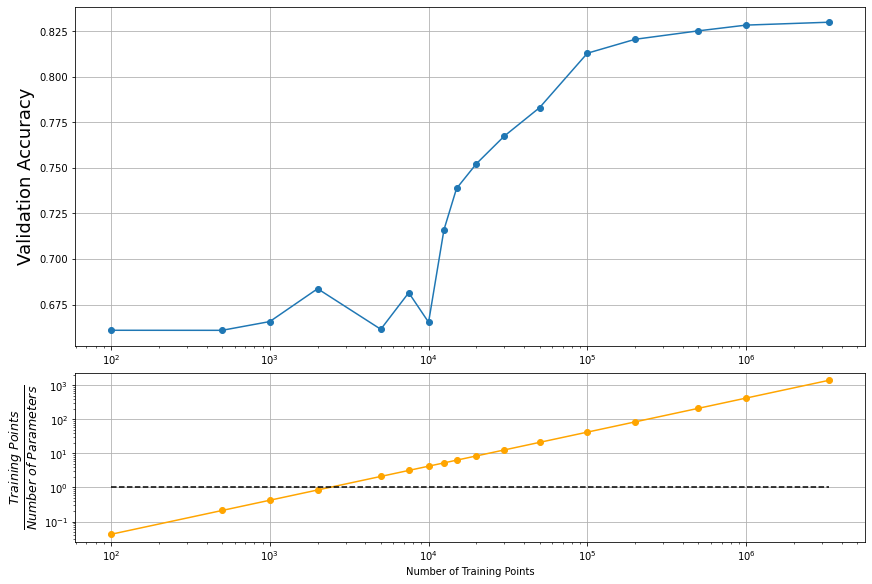

In [76]:
loss_ = [x[-1] for x in val_losses]
acc_ = [x[-1] for x in val_accuracies]

trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
ratio = training_size / trainable_params


mosaic = """
    A
    A
    B
"""

fig = plt.figure(constrained_layout= True, figsize = (12,8))

ax_dict = fig.subplot_mosaic(mosaic)

ax_dict["A"].plot(training_size, acc_, "-o")
ax_dict["A"].set_xscale("log");
ax_dict["A"].set_ylabel("Validation Accuracy", size = 18);
ax_dict["A"].grid()

ax_dict["B"].plot(training_size, ratio, "-o", color = "orange")
ax_dict["B"].set_xscale("log");
ax_dict["B"].set_yscale("log");
ax_dict["B"].hlines(1, training_size[0], training_size[-1], linestyles = "dashed", color = "k")
ax_dict["B"].grid()
ax_dict["B"].set_ylabel(r"$\frac{Training\ Points}{Number\ of\ Parameters}$", size = 18);

plt.xlabel("Number of Training Points");


In [77]:
import shap

In [112]:
f = lambda x: model.predict(x)
med = np.median(x_train, axis = 0).reshape((1,x_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(x_val[:1000])


Permutation explainer: 1001it [16:20,  1.01it/s]                          


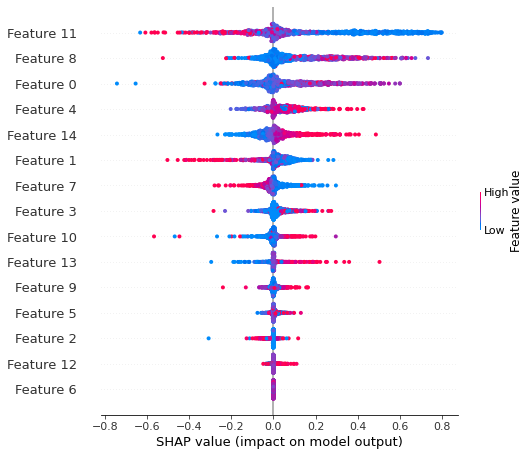

In [123]:
shap.plots.beeswarm(shap_values, max_display = 20)

In [126]:
train_keys

['ane',
 'ate',
 'autor',
 'machtor',
 'x',
 'zeff',
 'gammae',
 'q',
 'smag',
 'alpha',
 'ani1',
 'ati0',
 'normni1',
 'ti_te0',
 'lognustar']